In [1]:
import ephem
from datetime import datetime
import numpy as np 

In [2]:
ephem.Sun()
sun = ephem.Sun()
obs = ephem.Observer()
obs.lon, obs.lat = '5.747832', '45.202847'
obs.date = datetime.utcnow()
sun.compute(obs)
sun.alt

0.7972851991653442

In [3]:
import pandas as pd
%matplotlib inline


In [4]:
import numpy as np 



def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the unit sphere  (specified in radian)

    All args must be of equal length.

    """
    lat1 = lat1
    lat2 = lat2
    #lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))

    return c
 
def inv_gnomomic_projection(x,y,theta_0,phi_0):
    rho = np.sqrt(x**2+y**2)
    c = np.arctan(rho)
    sin_c = np.sin(c)
    cos_c = np.cos(c) 
    
    phi = np.arcsin(cos_c*np.sin(phi_0)+x*sin_c*np.cos(phi_0)/rho)
    theta = theta_0 +np.arctan(y*sin_c/(rho*np.cos(phi_0)*cos_c-x*np.sin(phi_0)*sin_c))
    
    return theta,phi

def gnomomic_projection(theta,phi,theta_0,phi_0):
    """
    from http://mathworld.wolfram.com/GnomonicProjection.html
    :param theta: pi/2 - lat
    :param phi: lon
    :param theta_0:
    :param phi_0:
    :return:
    """
    c = haversine_np(phi, theta, phi_0, theta_0)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    cos_c = np.cos(c)

    sin_theta = np.sin(theta-theta_0)
    cos_theta = np.cos(theta-theta_0)

    y = cos_phi*sin_theta/cos_c
    x = (np.cos(phi_0)*sin_phi - np.sin(phi_0)*cos_phi*cos_theta)/cos_c

    return x,y

theta_min = -15/180*np.pi
theta_max = -45/180*np.pi
phi_min = -45/180*np.pi
phi_max = 45/180*np.pi
        
n= 20

theta, phi = np.meshgrid(np.linspace(theta_min, theta_max, n),
                         np.linspace(phi_min,   phi_max,   n))
theta_0 = 0.1
phi_0 = 0.
x,y = gnomomic_projection(theta=theta,phi=phi,phi_0 = phi_0, theta_0 = theta_0)
theta_, phi_ = inv_gnomomic_projection(x,y,theta_0=theta_0, phi_0=phi_0)

df = pd.DataFrame(data = [theta.ravel(),phi.ravel(),x.ravel(),y.ravel(),
                          theta_.ravel(),phi_.ravel()],index=['theta','phi','x','y','theta_','phi_',]).T


In [5]:
#%timeit theta_, phi_ = inv_gnomomic_projection(x,y,theta_0=theta_0, phi_0=phi_0)


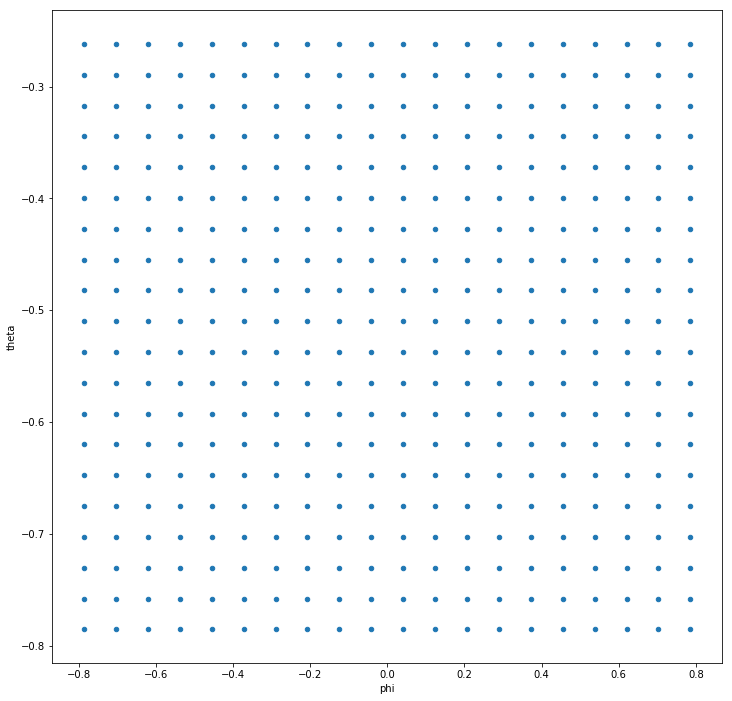

In [6]:
df.plot.scatter(x='phi',y='theta',figsize=[12,12])

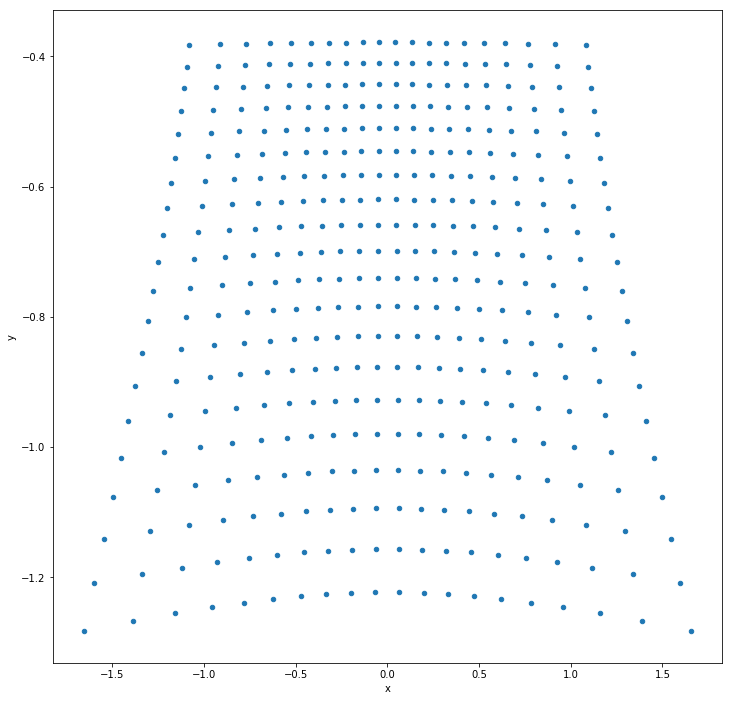

In [7]:
df.plot.scatter(x='x',y='y',figsize=[12,12])

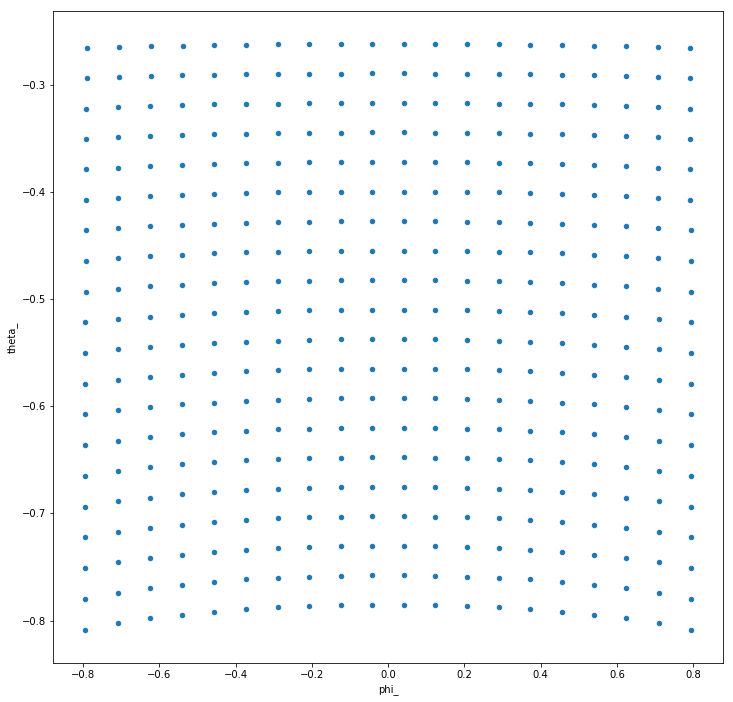

In [137]:
df.plot.scatter(x='phi_',y='theta_',figsize=[12,12])

In [138]:
# screen height and width 
height = 1080
width = 1600

vertical_fov = np.array([-10,50])/180*np.pi
horizontal_fov = np.array([-0,80])/180*np.pi

theta_0 = vertical_fov.mean()
phi_0 = horizontal_fov.mean()

y_lim = np.tan(vertical_fov-theta_0)
x_lim = np.tan(horizontal_fov-phi_0)
    
# y_lim = np.tan(vertical_fov) 
# x_lim = np.tan(horizontal_fov)


x, y = np.meshgrid(np.linspace(x_lim[0], x_lim[1], n),
                         np.linspace(y_lim[0], y_lim[1],   n))

# theta, phi = np.meshgrid(np.linspace(theta_min, theta_max, n),
#                          np.linspace(phi_min,   phi_max,   n))
# theta_0 = 0#y_lim.mean()
# phi_0 = 0#x_lim.mean()
#x,y = gnomomic_projection(theta=theta,phi=phi,phi_0 = phi_0, theta_0 = theta_0)
theta, phi = inv_gnomomic_projection(x,y,theta_0=0, phi_0=0)

x_,y_ = gnomomic_projection(theta=theta,phi= phi,theta_0=0, phi_0 = 0)

theta +=theta_0
phi +=phi_0
theta *= 180/np.pi
phi *= 180/np.pi

df = pd.DataFrame(data = [theta.ravel(),phi.ravel(),x.ravel(),y.ravel(),
                          x.ravel(),y_.ravel()],index=['theta','phi','x','y','x_','y_',]).T

In [139]:
y_lim

array([-0.57735027,  0.57735027])

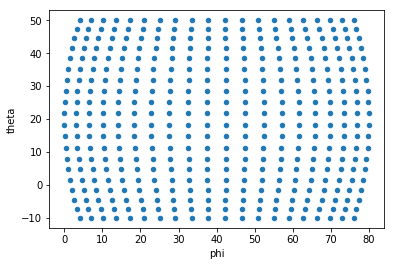

In [140]:
df.plot.scatter(x='phi',y='theta')

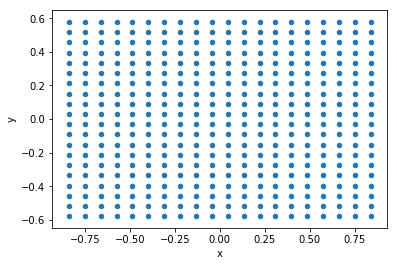

In [141]:
df.plot.scatter(x='x',y='y')

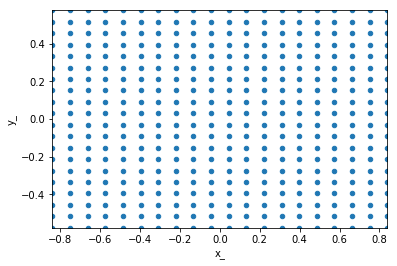

In [142]:
df.plot.scatter(x='x_',y='y_',xlim=x_lim,ylim=y_lim)

In [9]:
from ephem import stars
import matplotlib.pylab as plt

In [10]:
%matplotlib inline

## Performance : 

50 fps time budget : 20 ms

- calculating the position of the 94 stars once : 0.7 ms
- collecting those position and converting them to scrren coordinates : 0.13 ms

In [11]:
1 / 50

0.02

In [12]:
from collections import defaultdict


In [13]:
#%%timeit 
dates = pd.date_range(start=datetime.utcnow(),periods=1,freq='1min')

obs = ephem.Observer()
obs.lon, obs.lat = '5.747832', '45.202847'

sun = ephem.Sun()

# obs.date = datetime.utcnow()
# sun.compute(obs)
# sun.alt
res = defaultdict(list)
for date in dates : 
    obs.date = date 
    for star_name,star in stars.stars.items(): 
        star.compute(obs)
        
        res[star_name].append((star.alt,star.az))
    sun.compute(obs)
    res['sun'].append((sun.alt,sun.az))

In [14]:
%%timeit
theta,phi = zip(*[pos[0] for star_name, pos in res.items()])
x,y = gnomomic_projection(theta=np.array(theta),phi=np.array(phi),theta_0=0,phi_0 = np.pi)

59.3 µs ± 195 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


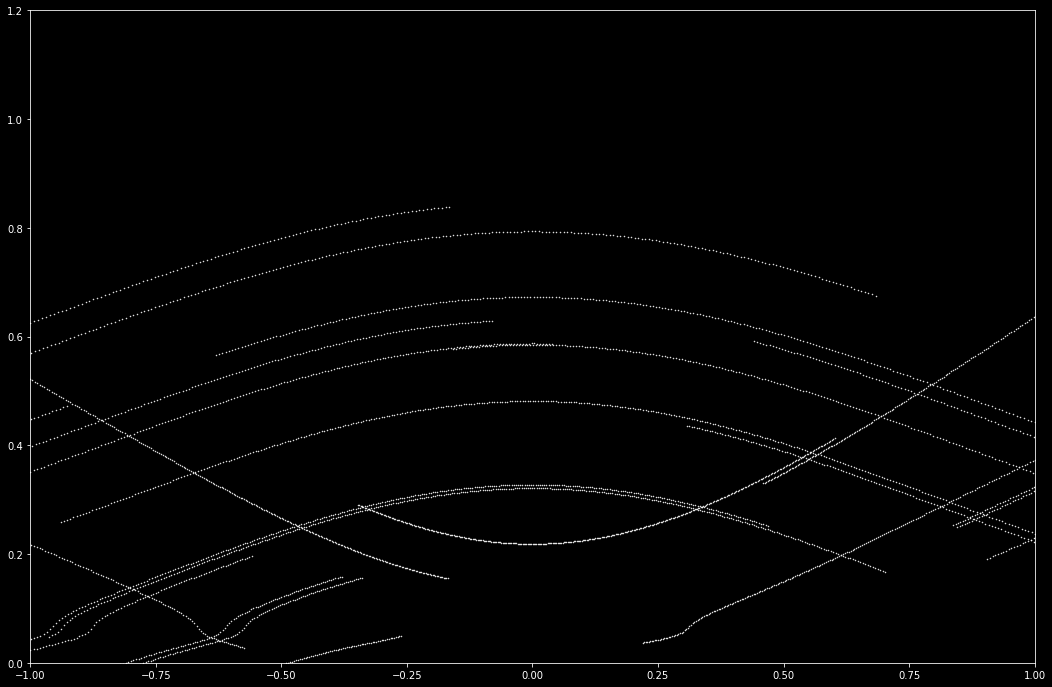

In [23]:
plt.style.use('dark_background')
f,ax = plt.subplots(1,1,figsize = [18,12,])
for star_name in res.keys():#stars.stars.items(): 
    #if star.dec > 0 :
    if True :
        ax.plot(x,y,'w.',markersize=1)
        ax.set_xlim([-1,1])
        ax.set_ylim([0,1.2])
        theta,phi = np.array(res[star_name]).T
        x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)
      
theta,phi= np.array(res['sun']).T
x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)

In [17]:
for star_name in res.keys():#stars.stars.items(): 
    #if star.dec > 0 :
    if True :
        
        theta,phi = np.array(res[star_name]).T
        x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)
        ax.plot(x,y,'w.',markersize=1)
        ax.set_xlim([-1,1])
        ax.set_ylim([0,1.2])
        ax.annotate(star_name, xy=(x[-1],y[-1]))
theta,phi= np.array(res['sun']).T
x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)

ValueError: Image size of 287833x32223 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1296x864 with 1 Axes>

In [15]:
ax.plot(x,y,'r')
ax.set_xlim([-1.5,1.5])
ax.set_ylim([0,1.2])
        #ax.text(x[0],y[0],star_name)

(0, 1.2)

ValueError: Image size of 89293x3481 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1296x864 with 1 Axes>

In [16]:
dates = pd.date_range(start=datetime.utcnow(),periods=60*6,freq='1min')

obs = ephem.Observer()
obs.lon, obs.lat = '5.747832', '45.202847'

sun = ephem.Sun()

# obs.date = datetime.utcnow()
# sun.compute(obs)
# sun.alt
from collections import defaultdict
res = defaultdict(list)
for date in dates : 
    obs.date = date 
    for star_name,star in stars.stars.items(): 
        star.compute(obs)
        
        res[star_name].append((star.alt,star.az))
    sun.compute(obs)
    res['sun'].append((sun.alt,sun.az))
plt.style.use('dark_background')
f,ax = plt.subplots(1,1,figsize = [18,12,])
for star_name in res.keys():#stars.stars.items(): 
    #if star.dec > 0 :
    if True :
        
        theta,phi = np.array(res[star_name]).T
        x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)
        ax.plot(x,y,'w.',markersize=1)
        ax.set_xlim([-1,1])
        ax.set_ylim([0,1.2])
        ax.annotate(star_name, xy=(x[-1],y[-1]))
theta,phi= np.array(res['sun']).T
x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)
ax.plot(x,y,'r')
ax.set_xlim([-1.5,1.5])
ax.set_ylim([0,1.2])
        #ax.text(x[0],y[0],star_name)
    #res[star_name] = np.vstack([x,y]).T 

(0, 1.2)

ValueError: Image size of 191912x32223 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1296x864 with 1 Axes>

# Sky alignement

## grid vertices

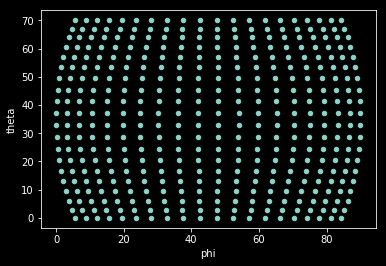

In [171]:
# screen height and width 
height = 1080
width = 1600

vertical_fov = np.array([0,70])/180*np.pi
horizontal_fov = np.array([0,90])/180*np.pi

theta_0 = vertical_fov.mean()
phi_0 = horizontal_fov.mean()

y_lim = np.tan(vertical_fov-theta_0)
x_lim = np.tan(horizontal_fov-phi_0)
    
# y_lim = np.tan(vertical_fov) 
# x_lim = np.tan(horizontal_fov)


x, y = np.meshgrid(np.linspace(x_lim[0], x_lim[1], n),
                         np.linspace(y_lim[0], y_lim[1],   n))

# theta, phi = np.meshgrid(np.linspace(theta_min, theta_max, n),
#                          np.linspace(phi_min,   phi_max,   n))
# theta_0 = 0#y_lim.mean()
# phi_0 = 0#x_lim.mean()
#x,y = gnomomic_projection(theta=theta,phi=phi,phi_0 = phi_0, theta_0 = theta_0)
theta, phi = inv_gnomomic_projection(x,y,theta_0=0, phi_0=0)

x_,y_ = gnomomic_projection(theta=theta,phi= phi,theta_0=0, phi_0 = 0)

theta +=theta_0
phi +=phi_0
theta *= 180/np.pi
phi *= 180/np.pi

df = pd.DataFrame(data = [theta.ravel(),phi.ravel(),x.ravel(),y.ravel(),
                          x.ravel(),y_.ravel()],index=['theta','phi','x','y','x_','y_',]).T

df.plot.scatter(x='phi',y='theta')#,xlim=x_lim,ylim=y_lim)

## Bodies positions

In [ ]:
stars.stars['Megrez']

(-2.800830152838839, 2.800830152838839)

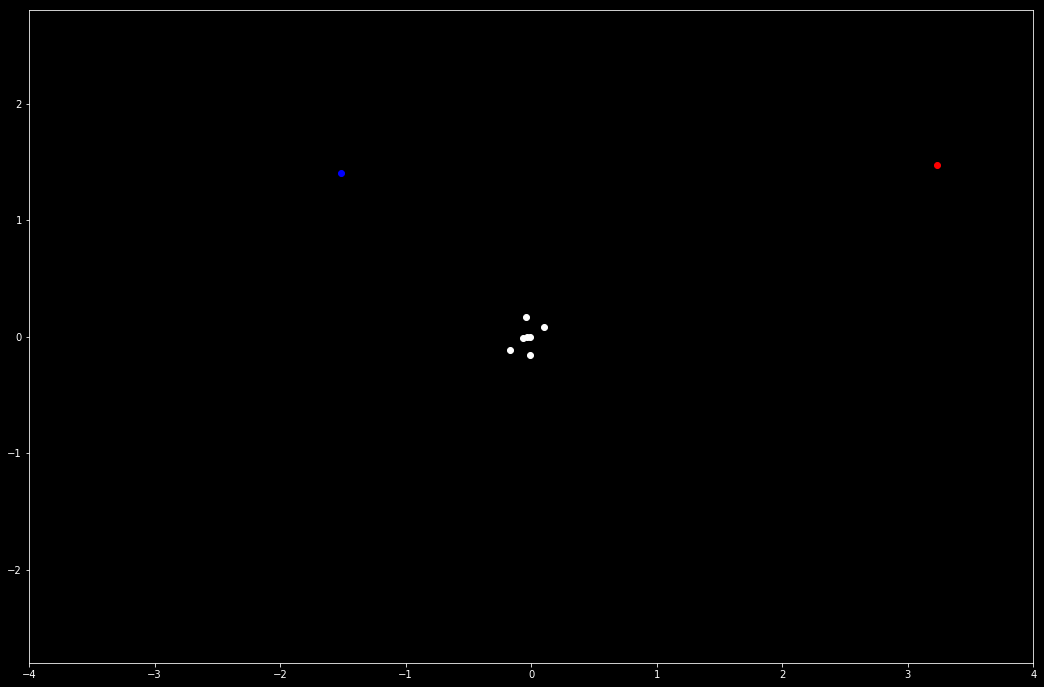

In [173]:
orion = ['Saiph','Bellatrix', 'Mintaka','Alnilam', 'Alnitak', 'Rigel', 'Betelgeuse']

dates = pd.date_range(start=datetime.utcnow(),periods=1,freq='1min')

obs = ephem.Observer()
obs.lon, obs.lat = '5.747832', '45.202847'

sun = ephem.Sun()
moon = ephem.Moon()


# obs.date = datetime.utcnow()
# sun.compute(obs)
# sun.alt
res = defaultdict(list)
for date in dates : 
    obs.date = date 
    for star_name in orion :
        star = stars.stars[star_name]
        star.compute(obs)
        
        res[star_name].append((star.alt-theta_0,star.az-phi_0+np.pi))
        
        
    sun.compute(obs)
    moon.compute(obs)
    res['moon'].append((moon.alt, moon.az+np.pi))
    res['sun'].append((sun.alt,sun.az+np.pi))

    
theta,phi = zip(*[pos[0] for star_name, pos in res.items()])
x,y = gnomomic_projection(theta=np.array(theta),phi=np.array(phi),theta_0=0,phi_0 = 0)
X = (x.ravel() - x_lim[0])/(x_lim[1]-x_lim[0])  * width
Y = (y.ravel() - y_lim[0])/ (y_lim[1]-y_lim[0]) * height

f,ax = plt.subplots(1,1,figsize = [18,12,])
ax.scatter(x[:-2],y[:-2],c='w')
ax.scatter(x[-2],y[-2],c='b')
ax.scatter(x[-1],y[-1],c='r')

ax.set_xlim(x_lim*4)
ax.set_ylim(y_lim*4)

In [168]:
np.array(res['sun'])*180/np.pi

array([[ 56.14455454, 420.66870952]])

In [163]:
ephem.__file__


'/home/pascal/anaconda/envs/py36/lib/python3.6/site-packages/ephem/__init__.py'

In [110]:
sun.az

3.91606068611145

(-0.5773502691896257, 0.5773502691896258)

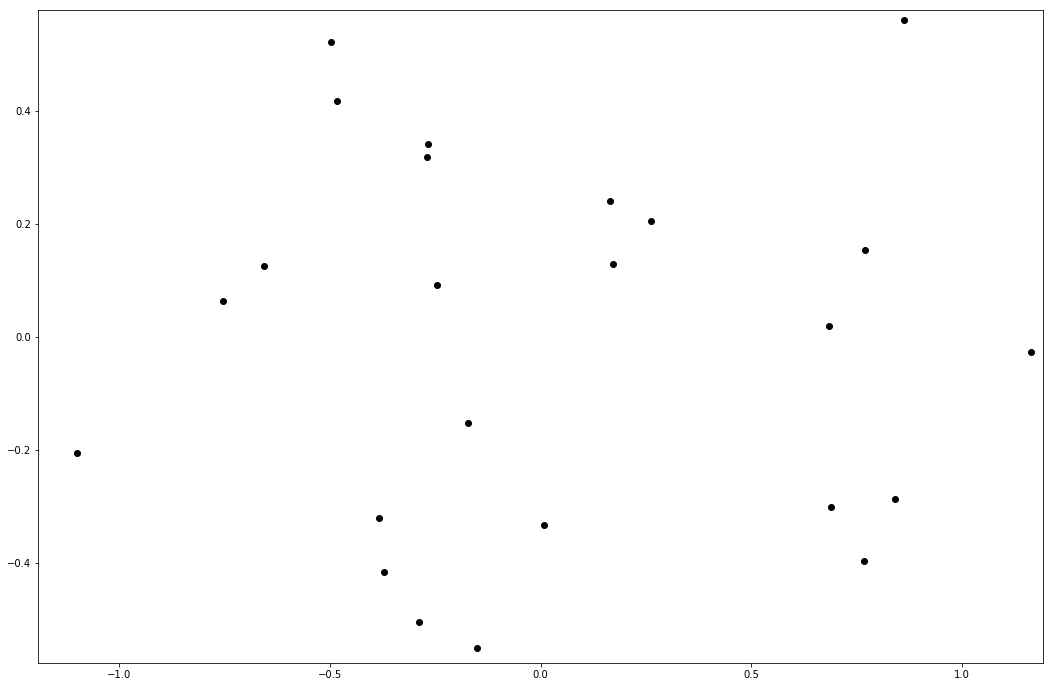

In [100]:
from blobformer.sky_models import simulate_color

In [ ]:
simulate_color(theta,phi,sun_theta_phi,turbidity)

In [ ]:
dates = pd.date_range(start=datetime.utcnow(),periods=2,freq='1min')

obs = ephem.Observer()
obs.lon, obs.lat = '5.7166700', '45.1666700'

sun = ephem.Sun()

# obs.date = datetime.utcnow()
# sun.compute(obs)
# sun.alt
from collections import defaultdict
res = defaultdict(list)
for date in dates : 
    obs.date = date 
    sun.compute(obs)
        
    res['sun'].append((sun.alt,sun.az,sun.mag))
plt.style.use('dark_background')
f,ax = plt.subplots(1,1,figsize = [18,12,])


#if True :

theta,phi,mag = np.array(res['sun']).T
x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)
ax.scatter(x,y,c=mag)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([0,1.2])


In [ ]:
obs.date = datetime.utcnow()
sun.compute(obs)
sun.alt

In [ ]:
mag.std()

In [ ]:
{star_name:star.dec for star_name,star in stars.stars.items()}

In [ ]:
a.dec

In [ ]:
import matplotlib.pylab as plt 

In [ ]:
plt.scatter(res['Altair'])

In [ ]:
theta,phi = np.array(res['Altair']).T
theta

In [ ]:
df_star = pd.DataFrame(res)

In [ ]:
df_star

In [ ]:
dates